In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy
import math
import random
import cvxopt
from cvxopt import matrix, solvers
import pypfopt
%matplotlib inline

In [2]:
tickers_list = ['TSLA','LAC',
                'AMZN', 'NFLX',
                'WMT', 'COST',
               'FL', 'RILY',
               'ENPH', 'SHOP',
               'PLUG', 'SEDG',
               'ETSY', 'MRTX',
               'TJX', 'NKE',
               'AAPL', 'FB',
               'GOOG', 'NVDA']

df = yf.download(tickers_list,'2017-01-01', '2020-12-31')['Adj Close']

[*********************100%***********************]  20 of 20 completed


In [3]:
df.head()

,AAPL,AMZN,COST,ENPH,ETSY,FB,FL,GOOG,LAC,MRTX,NFLX,NKE,NVDA,PLUG,RILY,SEDG,SHOP,TJX,TSLA,WMT
Date,,,,,,,,,,,,,,,,,,,,
2017-01-03,27.332470,753.669983,142.592804,1.05,11.88,116.860001,62.968292,786.140015,2.95,5.20,127.489998,49.434593,25.173815,1.21,12.511638,13.20,42.820000,35.254723,43.397999,62.291290
2017-01-04,27.301880,757.179993,142.619583,1.15,11.97,118.690002,64.083176,786.900024,2.95,5.50,129.410004,50.471214,25.761150,1.30,12.613914,14.40,44.139999,35.801414,45.397999,62.654182
2017-01-05,27.440720,780.450012,145.431641,1.12,12.40,120.669998,63.003410,794.020020,3.00,5.90,131.809998,50.461704,25.107189,1.26,12.682100,13.80,47.680000,35.581806,45.349998,62.790264
2017-01-06,27.746634,795.989990,145.360214,1.11,13.08,123.410004,62.143105,806.150024,2.95,5.70,131.070007,51.270084,25.442806,1.25,13.125290,13.75,46.900002,35.502377,45.801998,61.928391
2017-01-09,28.000778,796.919983,143.699753,1.11,12.35,124.900002,62.213364,806.650024,3.25,5.55,130.949997,50.766045,26.474337,1.25,13.125290,13.50,47.180000,35.558437,46.256001,62.336647


In [4]:
dup = len(df) - df.nunique()
print(dup)

AAPL     12
AMZN     11
COST     11
ENPH    225
ETSY     78
FB       47
FL       41
GOOG      8
LAC     553
MRTX    175
NFLX     26
NKE      28
NVDA     10
PLUG    590
RILY    242
SEDG    135
SHOP     12
TJX      56
TSLA     18
WMT      29
dtype: int64


In [5]:
assets = pd.DataFrame(df.columns)
assets = assets.to_latex(index = False)

In [6]:
'''
This cell computes the number of missing values in the datframe
'''
stocks = []
nans = []
for i in df.columns:
    stocks.append(i)
    count_nan = df[str(i)].isna().sum()
    nans.append(count_nan)

nan_df = pd.DataFrame(stocks)
nan_df['nans'] = nans

In [7]:
nan_df.columns = ['stock', 'nan values']

In [8]:
#calculate the daily returns of each stock
daily_returns = df.pct_change()
daily_returns = daily_returns.iloc[1:,:]

# daily_returns = daily_returns.iloc[1:,:5].head()
# print(daily_returns.to_latex(index = True))

In [9]:
#get average daily returns
mean_daily_returns = daily_returns.values.mean(axis=0)
mean_daily_returns

array([1.77401663e-03, 1.65138440e-03, 1.05087650e-03, 6.55441517e-03,
       3.35582230e-03, 1.07308596e-03, 8.21272590e-05, 9.43663619e-04,
       2.47451271e-03, 5.09845861e-03, 1.71778829e-03, 1.21396439e-03,
       2.09792718e-03, 4.58974656e-03, 1.41313167e-03, 3.92284348e-03,
       3.84744886e-03, 8.35534083e-04, 3.51622197e-03, 9.27202345e-04])

In [10]:
#Normalise daily returns and calculate covariance matrix, eigen values and eigen vectors
Y = daily_returns.values - mean_daily_returns
# l = pd.DataFrame(Y)
# print(l.head().to_latex(index = False))
cov = np.cov(Y.T)
l = pd.DataFrame(cov)
print(l.head().to_latex(index = False))
eigen_values, eigen_vectors = np.linalg.eig(cov)

\begin{tabular}{rrrrrrrrrrrrrrrrrrrr}
\toprule
      0  &       1  &       2  &       3  &       4  &       5  &       6  &       7  &       8  &       9  &       10 &       11 &       12 &       13 &       14 &       15 &       16 &       17 &       18 &       19 \\
\midrule
0.000398 & 0.000246 & 0.000141 & 0.000353 & 0.000282 & 0.000263 & 0.000155 & 0.000237 & 0.000271 & 0.000267 & 0.000244 & 0.000181 & 0.000368 & 0.000285 & 0.000192 & 0.000290 & 0.000315 & 0.000168 & 0.000310 & 0.000109 \\
0.000246 & 0.000372 & 0.000121 & 0.000279 & 0.000296 & 0.000261 & 0.000085 & 0.000230 & 0.000207 & 0.000197 & 0.000307 & 0.000129 & 0.000338 & 0.000249 & 0.000133 & 0.000211 & 0.000352 & 0.000095 & 0.000280 & 0.000088 \\
0.000141 & 0.000121 & 0.000195 & 0.000145 & 0.000148 & 0.000108 & 0.000111 & 0.000115 & 0.000121 & 0.000144 & 0.000125 & 0.000109 & 0.000171 & 0.000140 & 0.000094 & 0.000126 & 0.000153 & 0.000109 & 0.000123 & 0.000122 \\
0.000353 & 0.000279 & 0.000145 & 0.003018 & 0.000591 & 0.000

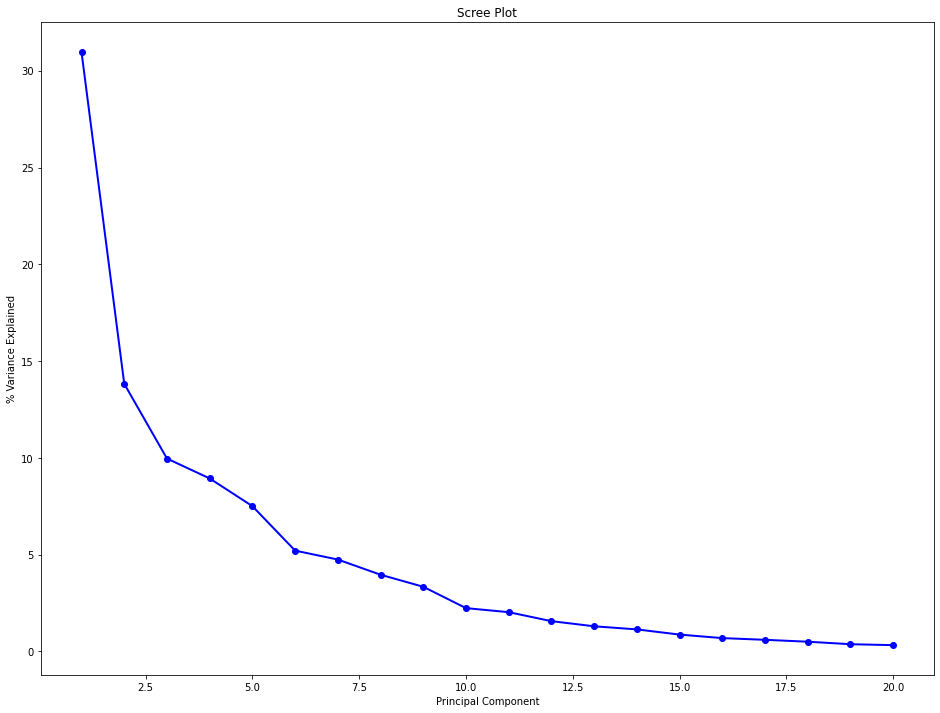

In [11]:
#Scree plot
x = eigen_values
w = []
z = []
cnt = 1
for i in x:
    w.append(100*(i/sum(x)))
    z.append(cnt)
    cnt+=1
    
w = sorted(w, key=float, reverse=True)
plt.rcParams["figure.figsize"] = (16, 12)
plt.plot(z, w,'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('% Variance Explained')
plt.show()

x=0
for i in range(0,10):
    x += w[i]

In [12]:
#calculate factor loadings
factor_loading = pd.DataFrame(eigen_vectors)
factor_loading.columns = ['FL1', 'FL2', 'FL3', 'FL4', 'FL5', 'FL6','FL7', 'FL8', 'FL9', 'FL10', 'FL11', 'FL12',
                   'FL13', 'FL14', 'FL15', 'FL16','FL17', 'FL18', 'FL19', 'FL20']
factor_loading.index = daily_returns.columns
factor_loading =factor_loading.iloc[:, :10]

In [21]:
#Determine highest contributer to each factor
m = []
for i in factor_loading.columns:
    a = min((factor_loading[i]))
    b = max(factor_loading[i])
    
    if abs(a) > abs(b):
        y =factor_loading[i].to_list()
        y = y.index(a)
        m.append(daily_returns.columns[y])
    else:
        y =factor_loading[i].to_list()
        y = y.index(b)
        m.append(daily_returns.columns[y])


 
print(m)

['ENPH', 'MRTX', 'ENPH', 'PLUG', 'LAC', 'FL', 'TSLA', 'SEDG', 'ETSY', 'SHOP']


In [14]:
#determine the factors to be used 
factors = np.matmul(Y , eigen_vectors)
factors = pd.DataFrame(factors)
factors = factors.iloc[:,0:10]
factors.columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6','F7', 'F8', 'F9', 'F10']
factors.mean(axis = 0)

F1    -1.808945e-18
F2    -4.764017e-19
F3     2.658183e-19
F4    -2.865314e-19
F5     2.692705e-19
F6    -7.914136e-19
F7     1.691571e-19
F8     2.157616e-19
F9    -1.449918e-19
F10   -1.449918e-19
dtype: float64

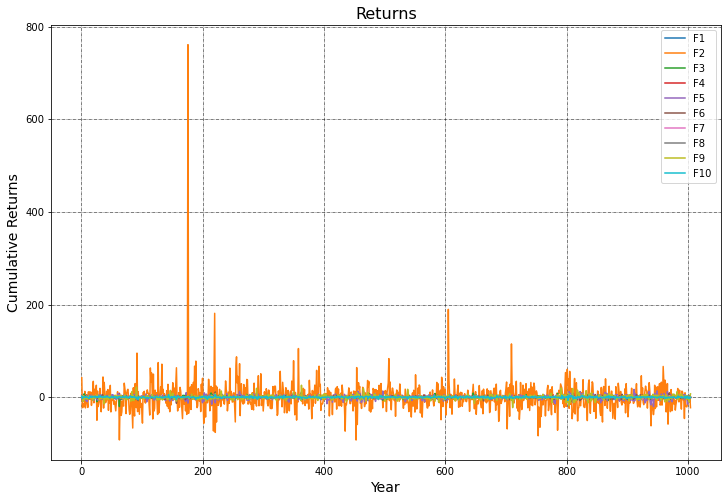

In [15]:
# from matplotlib import cm
data = factors
# Plot all the close prices
((data.pct_change()+1).cumprod()).plot(figsize=(12, 8))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Returns", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [31]:
#Minimise for volatility and calculate the optimal weighting of each factor

daily_factor_returns = factors.mean() #should be close to zero
annual_factor_returns = daily_factor_returns*252
cov = factors.cov()*252 #annualised covariance matrix

optimiser  = pypfopt.EfficientFrontier(annual_factor_returns,cov, solver='CVXOPT', weight_bounds=(0,1))
optimal_factor_weights = optimiser.efficient_risk(0.3)
perf = optimiser.portfolio_performance(verbose=True)

Expected annual return: -0.0%
Annual volatility: 19.4%
Sharpe Ratio: -0.10


In [32]:
#Determine the optimal portfolio

eigen_vectors = pd.DataFrame(eigen_vectors)
factor_eigen_vectors = eigen_vectors.iloc[:,0:10]
factor_eigen_vectors = abs(factor_eigen_vectors)
factor_eigen_vectors = factor_eigen_vectors/factor_eigen_vectors.sum(axis=0) #weighting of each stock in each factor

mean_annual_returns = mean_daily_returns*252 #annual returns of each stock

factor_weights = []
for i in factors.columns:
    factor_weights.append(optimal_factor_weights[i]) #converts dictionary to list
factor_weights


''' 
This next line mulitplies the weightings of each stock in a given factor 
by the optimised weighting of the given factor. For example, if the optimiser shown 
above allocates a weighting of 0.05 to factor 1, then the proportion of all the stocks in 
factor 1 is multiplied by 0.05
'''
factor_eigen_vectors.iloc[:, 0:] *= factor_weights


'''
These two lines calculate the sum of all stocks accross all factors to get a weighted average
of each factors optimal portfolio weighting, this is then used as the final portfolio weighting.
To get the annual return of the portfolio, the weightings are multiplied by the mean annual return of
their respective stocks
'''
portfolio_weights = factor_eigen_vectors.sum(axis=1)
portfolio_annual_return = portfolio_weights*mean_annual_returns

r = round(sum(100*portfolio_annual_return),2)
print(f"Annual Return: {r}%")

Annual Return: 72.9%


In [33]:
#final portfolio allocation
portfolio_weights = pd.DataFrame(portfolio_weights)
portfolio_weights.index = daily_returns.columns
portfolio_weights.columns = ['Stock_Weighting']
portfolio_weights

,Stock_Weighting
AAPL,0.024686
AMZN,0.025715
COST,0.014992
ENPH,0.071698
ETSY,0.092127
FB,0.031616
FL,0.083749
GOOG,0.026612
LAC,0.074304
MRTX,0.048653


<AxesSubplot:ylabel='Stock_Weighting'>

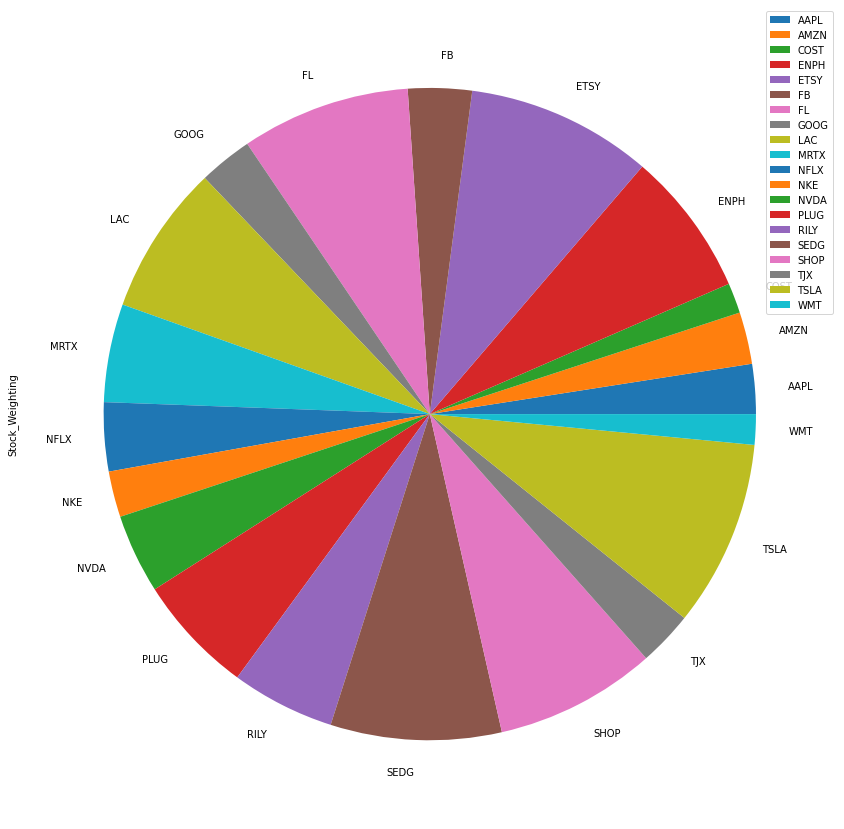

In [34]:
#portfolio visualisation
portfolio_weights.plot.pie(y='Stock_Weighting', figsize=(15, 15))